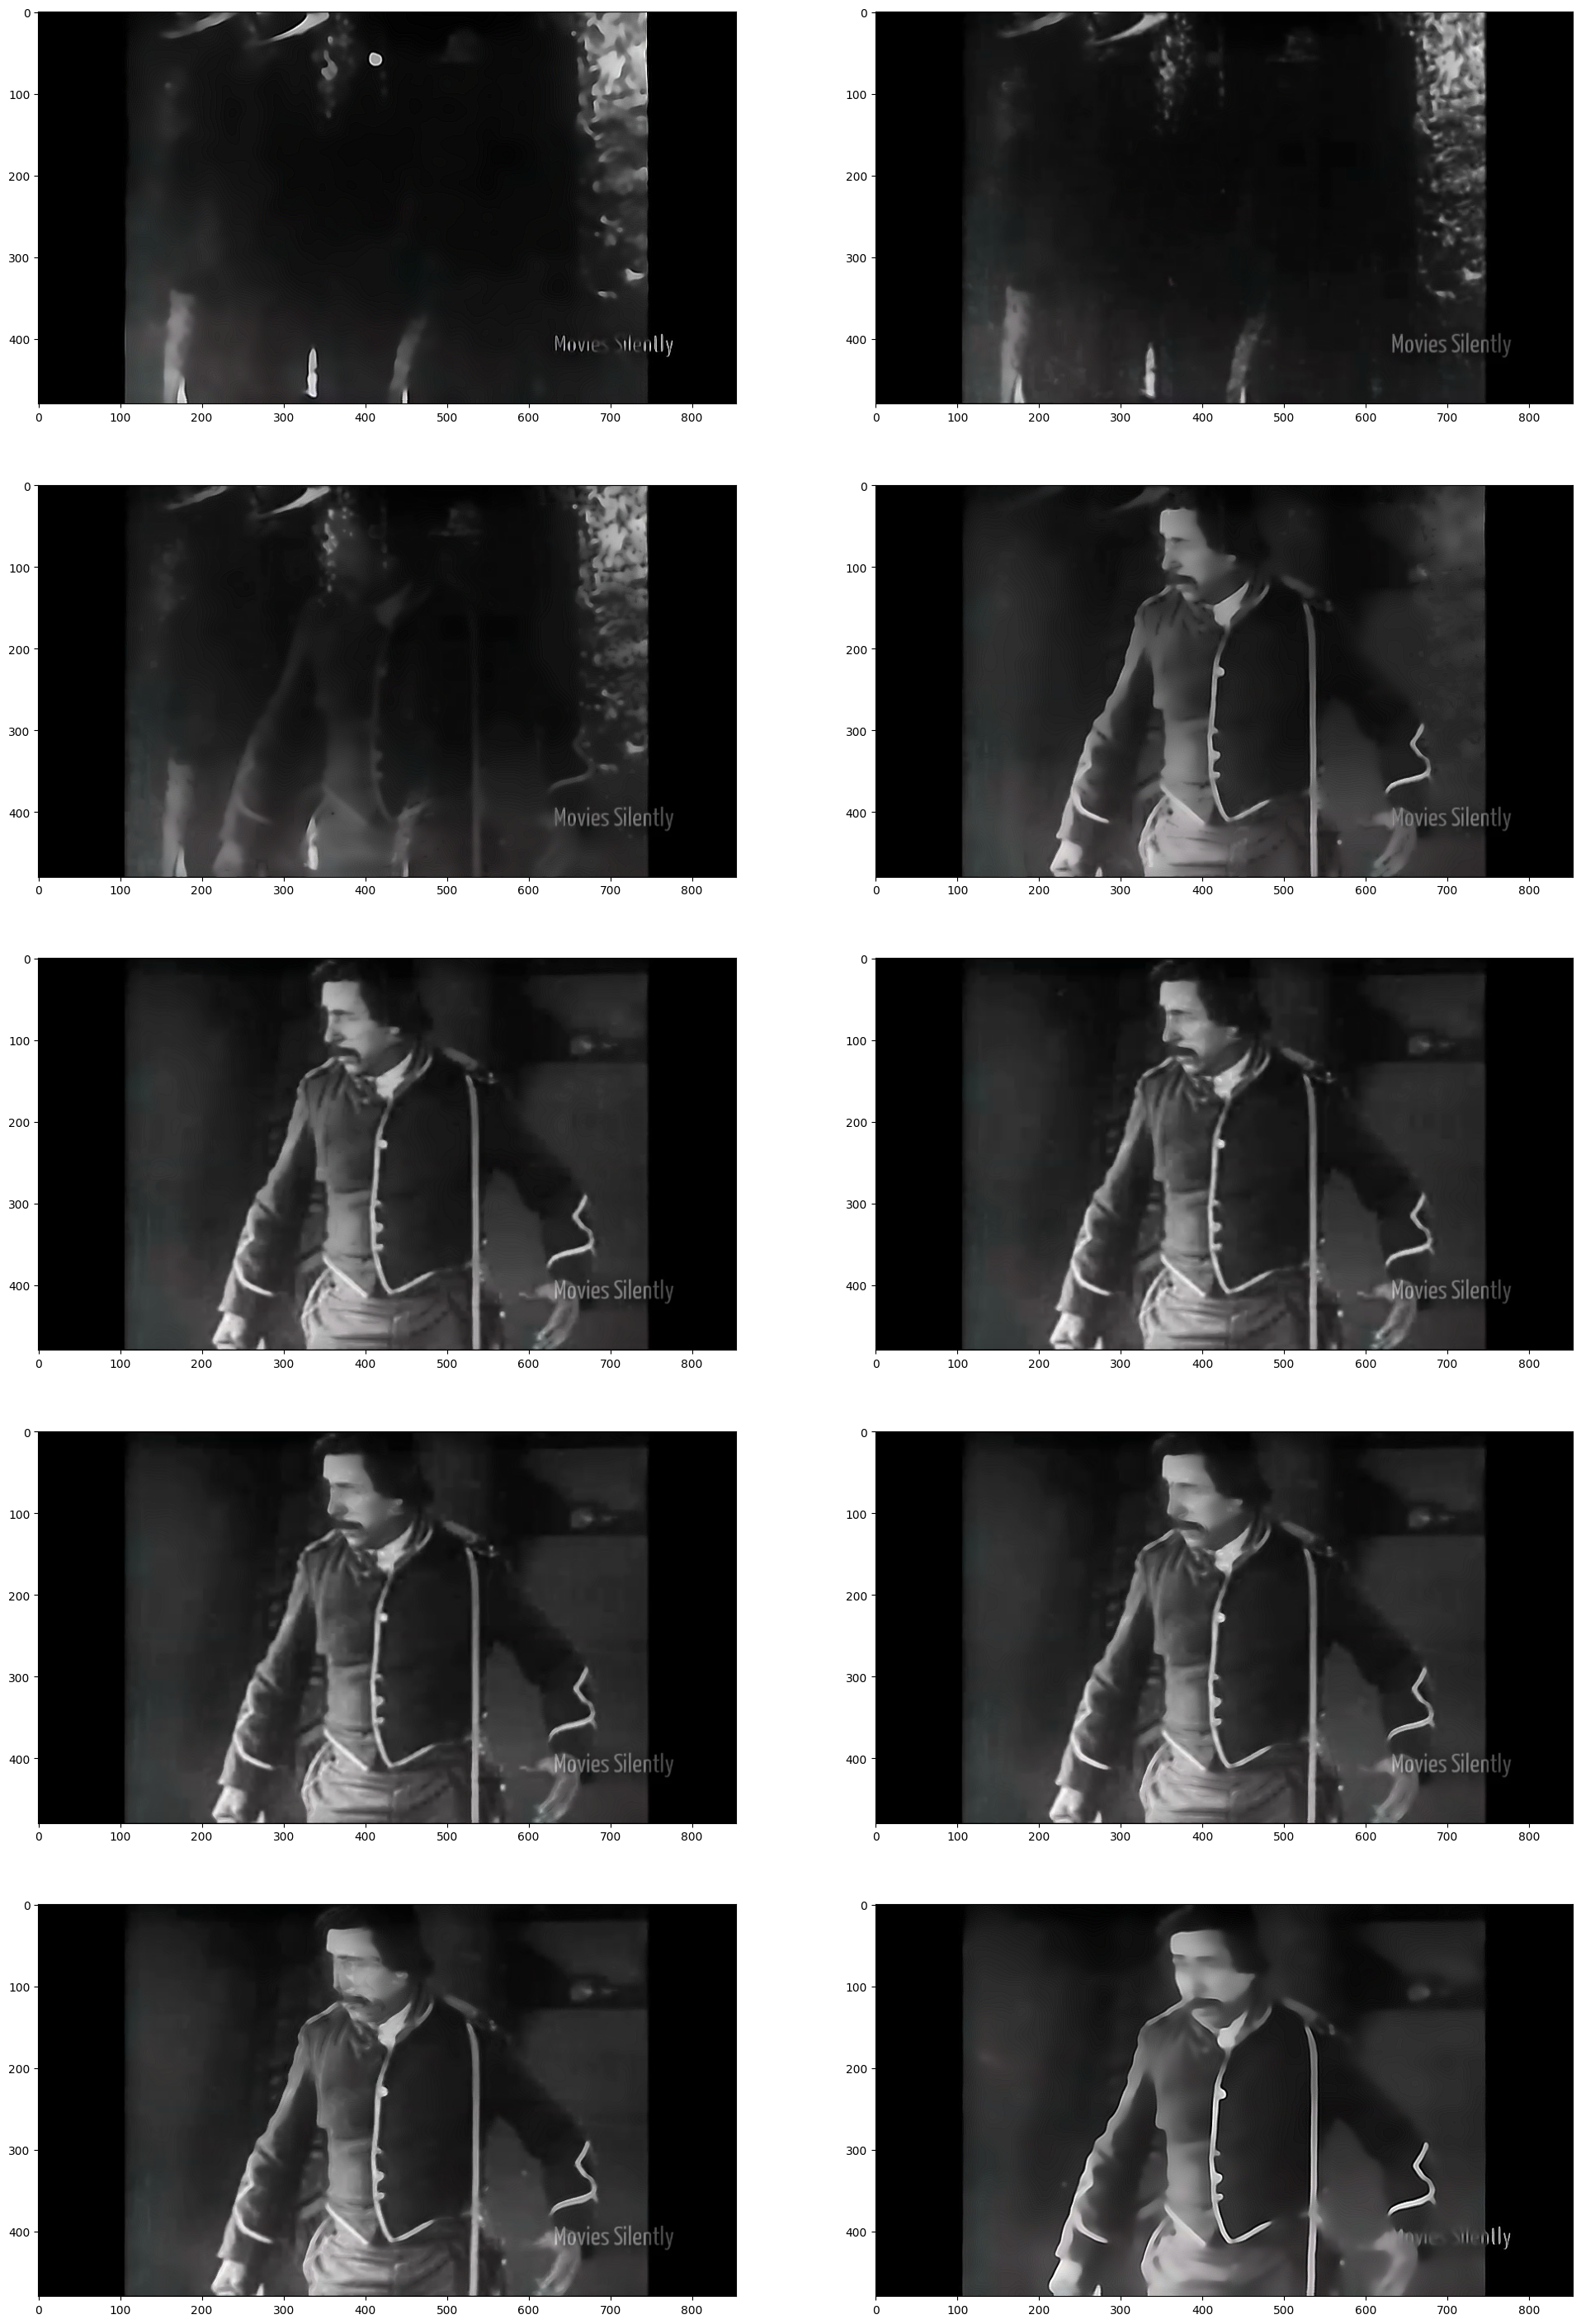

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded


def process_frames(video_cap: cv2.VideoCapture) -> np.ndarray:
    """
    This function takes in a video capture object and returns a numpy array of processed frames.
    
    process_frames read in the first 10 frames of the video and processes them with the goal of restoring the old film.
    
    Explanation of the process:
    
        First the frames are denoised using non-local means [1] denoising with openCV's fastNlMeansDenoisingColored function.
        
        I am using the colored version as there could be old film that has color and I want to preserve that.
        
        I use a bilateral filter [2] to smooth the image while preserving edges further reducing noise.
        
        Then a sharpen kernel is applied to enhance some of the edges and details in the image that may have been lost in the denoising.
        
        After that the frame buffer is checked to see if there are any previous or next frames to stabilize the current frame.
        
        If there are previous and next frames then the current frame is stabilized by taking the median of the previous, current and next frames.
        
        If there are no previous or next frames then the current frame is left as is.
        
        The brightness of the process frame is normalized with the original frame to make sure the processed frames brightness is similar to the original frames.
        
    
    
    
    Experimentation:
    
        For my testing I ran process_frames on every frame in the video and saved the output as an mp4. For the whole video it takes about 9ish minutes to run on my desktop
        
        Initially I tried Median Blur and it did a good job and then tried bilateral filtering and it looked better
        
        Tried weiner deblurring to handle some motion blur but it was leaving weird artifacts (it looked like vibrating aura around the edges of the moving people like when you look at the horizontal and vertical gradients of an image)
        
        Temporal median filtering was used for motion stabilization and jitter removal
        
        Tried optical flow but could not get it to work had problems with dimension sizes 
        
        I noticed that the video was very bright so I normalized the brightness of the processed frames to the original frames 
        
        I tried CLAHE instead of brightness normalization but it made the image look worse it even seemed to add back some of the blips that were removed by the denoising
    
    
    Paper citations:
    [1] A. Buades, B. Coll and J. . -M. Morel, "A non-local algorithm for image denoising," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005, pp. 60-65 vol. 2, doi: 10.1109/CVPR.2005.38.
    [2] Bilaterl filtering     C. Tomasi and R. Manduchi, "Bilateral filtering for gray and color images," Sixth International Conference on Computer Vision (IEEE Cat. No.98CH36271), Bombay, India, 1998, pp. 839-846, doi: 10.1109/ICCV.1998.710815.
    
    """
    frames_to_read = 10
    processed_frames = []
    frame_buffer = []

    noise_reduction_strength = 30
    bilateral_diameter = 9
    sigma_color = 75
    sigma_space = 75
    sharpening_kernel = np.array([[-1, -1, -1], [-1,  9, -1], [-1, -1, -1]])

    while len(frame_buffer) < frames_to_read:
        ret, frame = video_cap.read()
        if not ret:
            break
        frame_buffer.append(frame)

    for i, frame in enumerate(frame_buffer):
        
        denoised_frame = cv2.fastNlMeansDenoisingColored(frame, None, noise_reduction_strength, noise_reduction_strength, 7, 21)
        blurred_frame = cv2.bilateralFilter(denoised_frame, bilateral_diameter, sigma_color, sigma_space)
        sharpened_frame = cv2.filter2D(blurred_frame, -1, sharpening_kernel)


        if i > 0:
            prev_frame = frame_buffer[i - 1]
            next_frame = frame_buffer[i + 1] if i + 1 < len(frame_buffer) else sharpened_frame

            frames_window = np.stack([prev_frame, sharpened_frame, next_frame], axis=0)
            stabilized_frame = np.median(frames_window, axis=0).astype(np.uint8)
        else:
            stabilized_frame = sharpened_frame


        
        original_mean_brightness = np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        processed_mean_brightness = np.mean(cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY))
        brightness_ratio = original_mean_brightness / processed_mean_brightness if processed_mean_brightness > 0 else 1
        normalized_frame = cv2.convertScaleAbs(stabilized_frame, alpha=brightness_ratio, beta=0)
        
        
        
        processed_frames.append(normalized_frame)

    return np.array(processed_frames)


# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(24, 36)

video_cap = cv2.VideoCapture('./Zorro.mp4')
[video_cap.read() for _ in range(88)]
frames = process_frames(video_cap)

video_cap.release()

for i in range(5):
    for j in range(2):
        axs[i, j].imshow(frames[i*2 + j])

# [cv2.imwrite(f"./frame_{i:02}.jpg", frame) for i, frame in enumerate(frames)]
plt.show()

In [53]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def process_frames2(video_cap: cv2.VideoCapture, num_frames) -> np.ndarray:
    """
    
    
    
    
    Experimentation:
    
    For my testing I ran process_frames on every frame in the video and saved the output as an mp4. For the whole video it takes about 9ish minutes on my desktop
    
    Initially tried Median Blur and it did a good job and then tried bilateral filtering and it looked better
    
    Tried weiner deblurring to handle some motion blur but it was leaving weird artifacts (it looked like vibrating aura around the edges of the moving people like when you look at the horizontal and vertical gradients of an image)
    
    Temporal median filtering was used for motion stabilization
    
    Tried optical flow but could not get it to work had problems with dimension sizes
    
    I noticed that the video was very bright so I normalized the brightness of the processed frames to the original frames
    
    I tried CLAHE instead of brightness normalization but it made the image look worse it even seemed to add back some of the blips that were removed by the denoising
    
    
    Paper citations:
    Non Local Means        A. Buades, B. Coll and J. . -M. Morel, "A non-local algorithm for image denoising," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005, pp. 60-65 vol. 2, doi: 10.1109/CVPR.2005.38.
    Bilaterl filtering     C. Tomasi and R. Manduchi, "Bilateral filtering for gray and color images," Sixth International Conference on Computer Vision (IEEE Cat. No.98CH36271), Bombay, India, 1998, pp. 839-846, doi: 10.1109/ICCV.1998.710815.
    
    """
    frames_to_read = num_frames
    processed_frames = []
    frame_buffer = []

    while len(frame_buffer) < frames_to_read:
        ret, frame = video_cap.read()
        if not ret:
            break
        frame_buffer.append(frame)
        
        
    
    noise_reduction_strength = 30
    bilateral_diameter = 9
    sigma_color = 75
    sigma_space = 75
    sharpening_kernel = np.array([[-1, -1, -1], [-1,  9, -1], [-1, -1, -1]])

    for i, frame in enumerate(frame_buffer):
        
        denoised_frame = cv2.fastNlMeansDenoisingColored(frame, None, noise_reduction_strength, noise_reduction_strength, 7, 21)
        blurred_frame = cv2.bilateralFilter(denoised_frame, bilateral_diameter, sigma_color, sigma_space)
        sharpened_frame = cv2.filter2D(blurred_frame, -1, sharpening_kernel)


        if i > 0:
            prev_frame = frame_buffer[i - 1]
            next_frame = frame_buffer[i + 1] if i + 1 < len(frame_buffer) else sharpened_frame

            frames_window = np.stack([prev_frame, sharpened_frame, next_frame], axis=0)
            stabilized_frame = np.median(frames_window, axis=0).astype(np.uint8)
        else:
            stabilized_frame = sharpened_frame


        
        original_mean_brightness = np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        processed_mean_brightness = np.mean(cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY))
        brightness_ratio = original_mean_brightness / processed_mean_brightness if processed_mean_brightness > 0 else 1
        normalized_frame = cv2.convertScaleAbs(stabilized_frame, alpha=brightness_ratio, beta=0)
        
        
        
        processed_frames.append(normalized_frame)

    return np.array(processed_frames)


In [50]:
video_cap2 = cv2.VideoCapture('./Zorro.mp4')

# Get the number of frames in the video
num_frames = int(video_cap2.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Number of frames in the video: {num_frames}")

frames2 = process_frames2(video_cap2, num_frames)
video_cap2.release()

Number of frames in the video: 704


KeyboardInterrupt: 

In [52]:
for frame in frames2:
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cv2.destroyAllWindows()

In [5]:
video = cv2.VideoCapture('./Zorro.mp4')

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
video.release()

In [9]:
# Write out frames2 to a video file 'mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('processed_video.mp4', fourcc, 30, (frames2.shape[2], frames2.shape[1]))

for frame in frames2:
    out.write(frame)

out.release()